In [1]:
%matplotlib inline
%precision 3

import montecarlo
import plot
import metrics
from decimal import Decimal
import simulate
import pandas
from pprint import pprint
import metrics
import withdrawal
import harvesting
import mortality

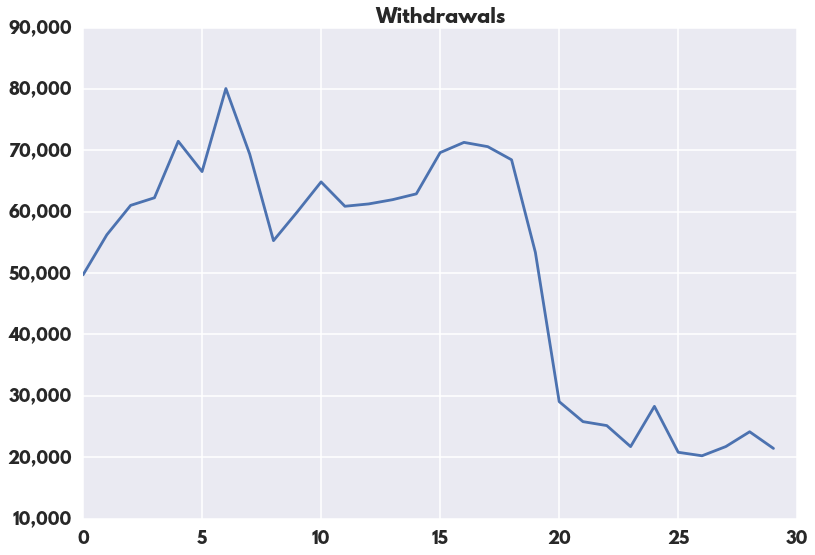

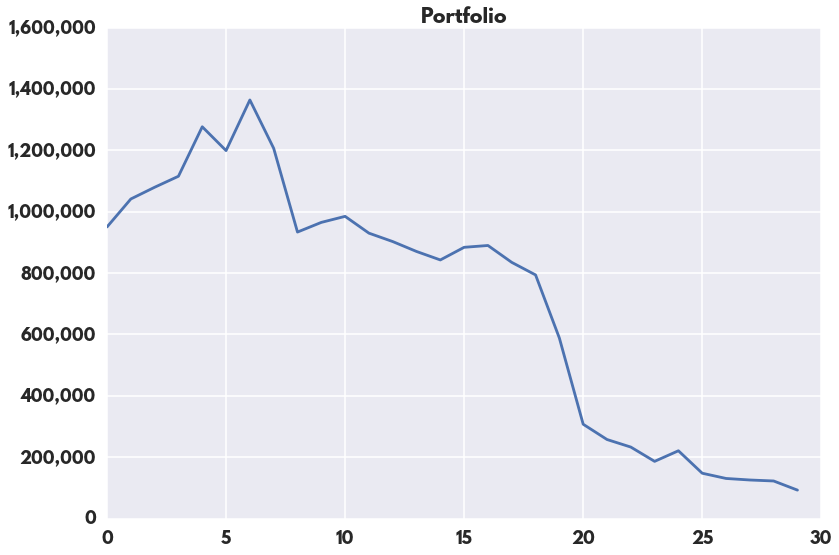

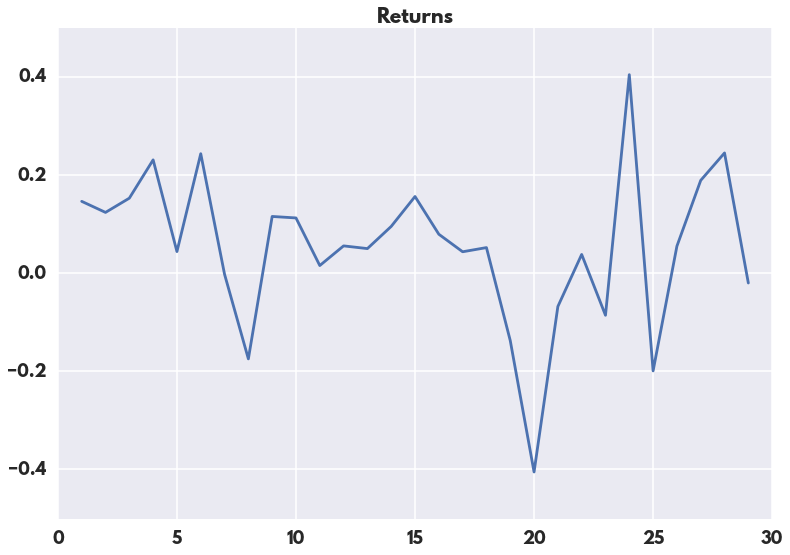

In [2]:
r = simulate.withdrawals(montecarlo.LowYieldsAutoRegression(), years=30, withdraw=withdrawal.VPW)
plot.plot([n.withdraw_r for n in r], title='Withdrawals')
plot.plot([n.portfolio_r for n in r], title='Portfolio')
plot.plot([n.returns for n in r], title='Returns', add_commas=False, zero_based=False)

In [3]:
pprint(['%.2f' % float(n.returns) for n in r[1:]])

['0.15',
 '0.12',
 '0.15',
 '0.23',
 '0.04',
 '0.24',
 '-0.00',
 '-0.17',
 '0.12',
 '0.11',
 '0.02',
 '0.06',
 '0.05',
 '0.10',
 '0.16',
 '0.08',
 '0.04',
 '0.05',
 '-0.14',
 '-0.41',
 '-0.07',
 '0.04',
 '-0.09',
 '0.40',
 '-0.20',
 '0.05',
 '0.19',
 '0.24',
 '-0.02']


In [4]:
def harness(iters, sim):
    successes = 0
    incomes = pandas.Series(iters)
    for i in range(iters):
        sim_results = sim()
        incomes.loc[i] = float(metrics.cew([(n.withdraw_pct_orig * 100) + Decimal('.01') for n in sim_results]))
        if sim_results[-1].portfolio_n > 0:
            successes += 1
    return (successes/iters, incomes)

def p_q(incomes):
    print('90th percentile income', incomes.quantile(.9))
    print('50th percentile income', incomes.quantile(.5))
    print('10th percentile income', incomes.quantile(.1))
    print('5th percentile income', incomes.quantile(.05))
    print('1st percentile income', incomes.quantile(.01))   

In [5]:
iters = 100
EM = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsAutoRegression(), years=30))
VPW = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsAutoRegression(),harvesting=harvesting.N_60_RebalanceHarvesting, withdraw=withdrawal.VPW, years=30))
ECM = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsAutoRegression(), withdraw=withdrawal.ECM, years=30))

In [6]:
for i in (EM, ECM, VPW):
    print('Success rate', i[0])
    p_q(i[1])
    print()

Success rate 0.95
90th percentile income 5.65879451681
50th percentile income 4.35623583484
10th percentile income 2.87632892433
5th percentile income 2.6699611333
1st percentile income 0.0135053900016

Success rate 0.91
90th percentile income 5.60336817561
50th percentile income 4.12556920379
10th percentile income 2.84136273728
5th percentile income 0.0232172890747
1st percentile income 0.0135021083614

Success rate 1.0
90th percentile income 6.40962311514
50th percentile income 4.48226812984
10th percentile income 2.53569108698
5th percentile income 1.98409594997
1st percentile income 1.17538788512



In [7]:
def run_one(years, stock_pct, a=None):
    bond_pct = (1 - stock_pct)
    
    if not a:
        a = montecarlo.LowYieldsAutoRegression(initial_yield=.025)
    
    returns = []
    
    for i, j in zip(range(years+1), a):
        stocks = float(j.stocks - j.inflation)
        bonds = float(j.bonds - j.inflation)
        total_return = (stocks * stock_pct) + (bonds * bond_pct)
        returns.append(total_return)
    return returns

In [8]:
a = montecarlo.LowYieldsAutoRegression(initial_yield=.025, logging=True)
run_one(30, .6, a=a)
print('inflation', a.log['inflation'].mean())
print('stocks', a.log['stocks'].mean())
print('bonds', a.log['bonds'].mean())
print('-' * 65)
print(a.log)

inflation 0.040743774740999494
stocks 0.09222600270203678
bonds 0.0714553829567765
-----------------------------------------------------------------
      y_prev     y_new        rc    stocks     bonds  inflation
0   0.025000  0.028056  0.019860  0.107132  0.112284   0.047500
1   0.028056  0.016244  0.000000  0.160544  0.036370   0.007252
2   0.016244  0.024584  0.000000 -0.197147 -0.012151   0.022496
3   0.024584  0.029929  0.003949 -0.245970 -0.019465   0.026909
4   0.029929  0.016448  0.000000  0.274859  0.070356  -0.003485
5   0.016448  0.026485  0.004520 -0.133173  0.036268   0.011850
6   0.026485  0.046587  0.027249  0.243210 -0.072775   0.066903
7   0.046587  0.052013  0.029009 -0.035523  0.059919   0.053767
8   0.052013  0.056983  0.023879  0.471014  0.014172   0.004237
9   0.056983  0.054082  0.034477  0.069244  0.045819   0.054344
10  0.054082  0.064425  0.016701 -0.038590 -0.015934   0.061943
11  0.064425  0.067761  0.063072  0.340087  0.049764   0.076178
12  0.067761  0.084

In [9]:
iters = 100

s = pandas.Series(iters)

for i in range(iters):
    years = 30
    stock_pct = .6
    ssr = metrics.ssr([Decimal(n) for n in run_one(years, stock_pct)])
    s[i] = float(ssr)

In [10]:
s.median()

0.047

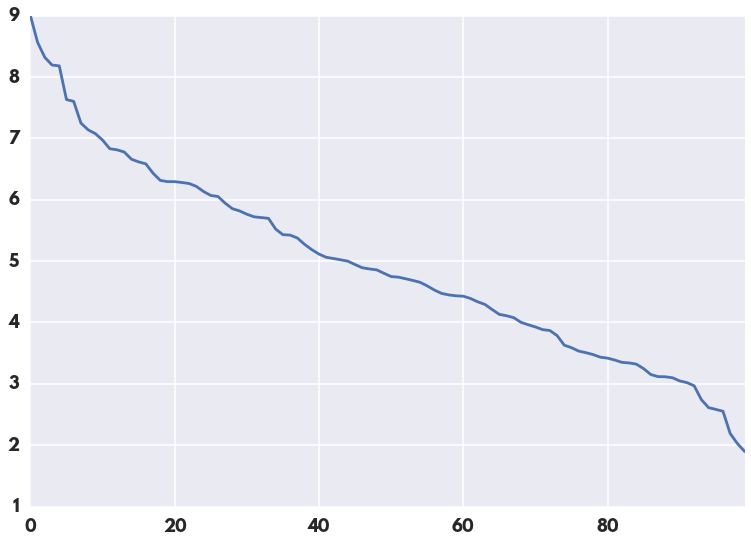

In [11]:
rates = pandas.Series(100)
for i in range(0, 100):
    q = s.quantile((100-i)/100)
    rates[i] = q * 100
rates.plot()

In [13]:
survival_fn = mortality.make_mortality(mortality.NVSS_2011)
iters = 100
successes = 0
for i in range(iters):
    final_age = mortality.gen_age(survival_fn)
    sim_results = simulate.withdrawals(montecarlo.LowYieldsAutoRegression(),
                         harvesting=harvesting.make_rebalancer(.6),
                         withdraw=lambda p, h: withdrawal.ConstantDollar(p, h, rate=Decimal('.033')),
                         years=final_age - 65)
    if sim_results[-1].portfolio_n > 0:
        successes += 1
print(successes/iters)

0.93


In [ ]:
iters = 100
successes = 0
couple = [mortality.Person(age=65, gender=mortality.MALE), mortality.Person(age=60, gender=mortality.FEMALE)]
for i in range(iters):
    final_age = 65 + mortality.gen_lifespan(couple)
    sim_results = simulate.withdrawals(montecarlo.historical[60],
                         harvesting=harvesting.make_rebalancer(.6),
                         withdraw=lambda p, h: withdrawal.ConstantDollar(p, h, rate=Decimal('.05')),
                         years=final_age - 65)
    if sim_results[-1].portfolio_n > 0:
        successes += 1
print(successes/iters)